In [1]:
#Usunąć # przy pobieraniu

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from textblob import TextBlob
from textblob import Word
#from gensim.scripts.glove2word2vec import glove2word2vec
#from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix, accuracy_score
#from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
#import string, xgboost
#from keras.preprocessing import text, sequence
#from keras import layers, models, optimizers

In [3]:
#Delete unnecesary column and chech length of messeage
normal = pd.read_csv('spam.csv', encoding = 'latin-1')
normal.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
normal.columns = ['label', 'content']

In [4]:
#stats

In [5]:
#Length of message
normal['char_count'] = normal['content'].apply(len)
#Counting words
normal['word_count'] = normal['content'].apply(lambda x: len(str(x).split(" ")))

In [6]:
#Length of average word in message
def avg_word_len(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

normal['avg_word_len'] = normal['content'].apply(lambda x: avg_word_len(x))

In [7]:
#Counting stopwords
#nltk.download('stopwords')
stop = stopwords.words('english')

normal['stopwords_count'] = normal['content'].apply(lambda x : len([x for x in x.split() if x in stop]))

In [8]:
#Counting specials and  numeric chars
normal['specials_count'] = normal['content'].apply(lambda x: len(re.sub('[\w]+', '', x)))
normal['numerics_count'] = normal['content'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

#Counting words with only upper letters
normal['uppers_count'] = normal['content'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

normal.head()

,label,content,char_count,word_count,avg_word_len,stopwords_count,specials_count,numerics_count,uppers_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,4.600000,4,28,0,0
1,ham,Ok lar... Joking wif u oni...,29,6,4.000000,0,11,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,4.571429,5,33,2,2
3,ham,U dun say so early hor... U c already then say...,49,11,3.545455,2,16,0,2
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,3.769231,5,14,0,1


In [9]:
#Histograms

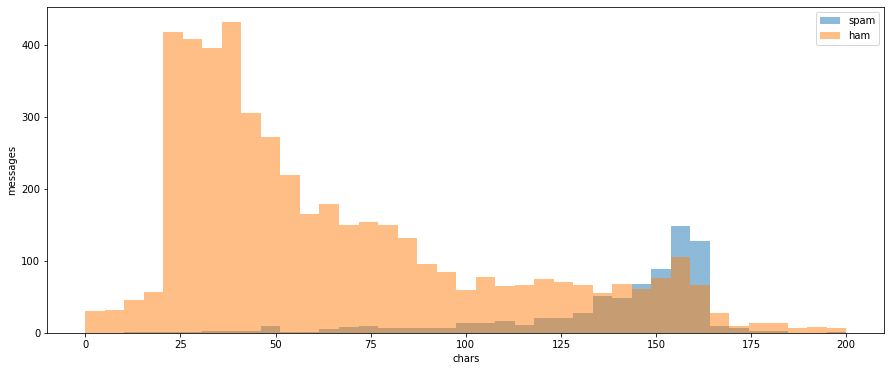

In [10]:
%matplotlib inline
plt.figure(figsize=(15,6))

bins = np.linspace(0, 200, num = 40)
plt.hist(normal[normal['label'] == 'spam']['char_count'], bins, alpha = 0.5, label = 'spam')
plt.hist(normal[normal['label'] == 'ham']['char_count'], bins, alpha = 0.5, label = 'ham')
plt.legend(loc ='upper right')
plt.xlabel('chars')
plt.ylabel('messages')
plt.show()

In [11]:
plt.close('all')

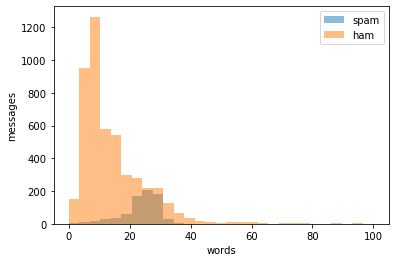

In [12]:
bins = np.linspace(0, 100, num = 30)
plt.hist(normal[normal['label'] == 'spam']['word_count'], bins, alpha = 0.5, label = 'spam')
plt.hist(normal[normal['label'] == 'ham']['word_count'], bins, alpha = 0.5, label = 'ham')
plt.legend(loc ='upper right')
plt.xlabel('words')
plt.ylabel('messages')
plt.show()

In [13]:
plt.close('all')

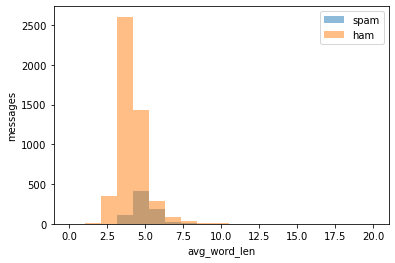

In [14]:
bins = np.linspace(0, 20, num = 20)
plt.hist(normal[normal['label'] == 'spam']['avg_word_len'], bins, alpha = 0.5, label = 'spam')
plt.hist(normal[normal['label'] == 'ham']['avg_word_len'], bins, alpha = 0.5, label = 'ham')
plt.legend(loc ='upper right')
plt.xlabel('avg_word_len')
plt.ylabel('messages')
plt.show()

In [15]:
plt.close('all')

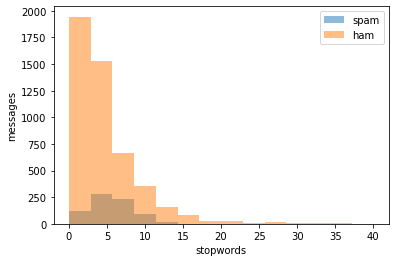

In [16]:
bins = np.linspace(0, 40, num = 15)
plt.hist(normal[normal['label'] == 'spam']['stopwords_count'], bins, alpha = 0.5, label = 'spam')
plt.hist(normal[normal['label'] == 'ham']['stopwords_count'], bins, alpha = 0.5, label = 'ham')
plt.legend(loc ='upper right')
plt.xlabel('stopwords')
plt.ylabel('messages')
plt.show()

In [17]:
plt.close('all')

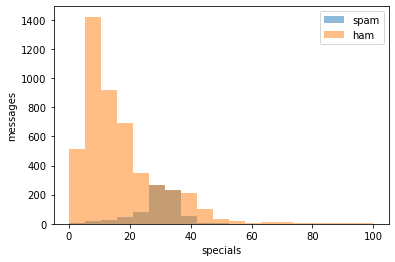

In [18]:
bins = np.linspace(0, 100, num = 20)
plt.hist(normal[normal['label'] == 'spam']['specials_count'], bins, alpha = 0.5, label = 'spam')
plt.hist(normal[normal['label'] == 'ham']['specials_count'], bins, alpha = 0.5, label = 'ham')
plt.legend(loc ='upper right')
plt.xlabel('specials')
plt.ylabel('messages')
plt.show()

In [19]:
plt.close('all')

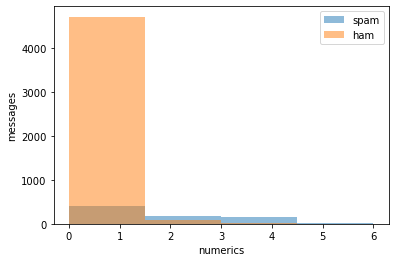

In [20]:
bins = np.linspace(0, 6, num = 5)
plt.hist(normal[normal['label'] == 'spam']['numerics_count'], bins, alpha = 0.5, label = 'spam')
plt.hist(normal[normal['label'] == 'ham']['numerics_count'], bins, alpha = 0.5, label = 'ham')
plt.legend(loc ='upper right')
plt.xlabel('numerics')
plt.ylabel('messages')
plt.show()

In [21]:
plt.close('all')

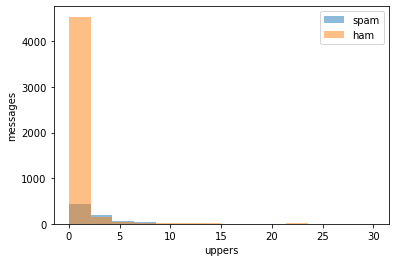

In [22]:
bins = np.linspace(0, 30, num = 15)
plt.hist(normal[normal['label'] == 'spam']['uppers_count'], bins, alpha = 0.5, label = 'spam')
plt.hist(normal[normal['label'] == 'ham']['uppers_count'], bins, alpha = 0.5, label = 'ham')
plt.legend(loc ='upper right')
plt.xlabel('uppers')
plt.ylabel('messages')
plt.show()

In [23]:
corr = normal.corr()
corr.style.background_gradient()

,char_count,word_count,avg_word_len,stopwords_count,specials_count,numerics_count,uppers_count
char_count,1.000000,0.974318,0.082962,0.764622,0.959271,0.354412,0.274843
word_count,0.974318,1.000000,-0.068013,0.820570,0.968128,0.316421,0.276789
avg_word_len,0.082962,-0.068013,1.000000,-0.149520,0.004025,0.064222,-0.020014
stopwords_count,0.764622,0.820570,-0.149520,1.000000,0.736301,0.029095,-0.005583
specials_count,0.959271,0.968128,0.004025,0.736301,1.000000,0.297234,0.264779
numerics_count,0.354412,0.316421,0.064222,0.029095,0.297234,1.000000,0.242672
uppers_count,0.274843,0.276789,-0.020014,-0.005583,0.264779,0.242672,1.000000


In [24]:
#Text processing

In [25]:
#save date before processing to comparize
normal['backup'] = normal['content']

#toLower
normal['content'] = normal['content'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#remove specials
normal['content'] = normal['content'].str.replace('[^\w\s]','')
#remove stopwords
normal['content'] = normal['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

<ipython-input-25-5b82003daf36>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  normal['content'] = normal['content'].str.replace('[^\w\s]','')


In [26]:
#remove often used words
freq = pd.Series(' '.join(normal['content']).split()).value_counts()[:10]
freq

u       1119
call     576
2        478
im       462
get      386
ur       384
4        287
dont     279
go       278
ok       277
dtype: int64

In [27]:
freq = list(freq.index)
normal['content'] = normal['content'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
normal['content'].head()

0    jurong point crazy available bugis n great wor...
1                                   lar joking wif oni
2    free entry wkly comp win fa cup final tkts 21s...
3                      dun say early hor c already say
4               nah think goes usf lives around though
Name: content, dtype: object

In [28]:
#remove rarely used words
freq = pd.Series(' '.join(normal['content']).split()).value_counts()[-10:]
freq

popping         1
outsider        1
cliffs          1
asian           1
nicky           1
messagepandy    1
loooooool       1
tadaaaaa        1
todayhe         1
forfeit         1
dtype: int64

In [29]:
freq = list(freq.index)
normal['content'] = normal['content'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
normal['content'].head()

0    jurong point crazy available bugis n great wor...
1                                   lar joking wif oni
2    free entry wkly comp win fa cup final tkts 21s...
3                      dun say early hor c already say
4               nah think goes usf lives around though
Name: content, dtype: object

In [30]:
#repair messages
#normal['content'][:5].apply(lambda x: str(TextBlob(x).correct()))

In [31]:
#Stemming
#st = PorterStemmer()
#normal['content'] = normal['content'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [32]:
#Tokenization
#nltk.download('punkt')
TextBlob(normal['content'][1]).words

WordList(['lar', 'joking', 'wif', 'oni'])

In [33]:
#Lemmatisation
#nltk.download('wordnet')
normal['content'] = normal['content'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [34]:
normal[['content', 'backup']].head(20)

,content,backup
0,jurong point crazy available bugis n great wor...,"Go until jurong point, crazy.. Available only ..."
1,lar joking wif oni,Ok lar... Joking wif u oni...
2,free entry wkly comp win fa cup final tkts 21s...,Free entry in 2 a wkly comp to win FA Cup fina...
3,dun say early hor c already say,U dun say so early hor... U c already then say...
4,nah think go usf life around though,"Nah I don't think he goes to usf, he lives aro..."
5,freemsg hey darling 3 week word back id like f...,FreeMsg Hey there darling it's been 3 week's n...
6,even brother like speak treat like aid patent,Even my brother is not like to speak with me. ...
7,per request melle melle oru minnaminunginte nu...,As per your request 'Melle Melle (Oru Minnamin...
8,winner valued network customer selected receiv...,WINNER!! As a valued network customer you have...
9,mobile 11 month r entitled update latest colou...,Had your mobile 11 months or more? U R entitle...


In [35]:
#Vectorisation

#toSave = normal

#toSave.drop(['label', 'backup', 'char_count', 'word_count', 'avg_word_len', 'stopwords_count', 'specials_count', 'numerics_count', 'uppers_count'], axis=1, inplace=True)

#toSave.head()


In [36]:

#toSave.to_csv('spam_clean.txt', index = False)

#glove_input = ('spam_clean.txt')
#word2vec_output = ('spam_clean.txt.word2vec')
#glove2word2vec(glove_input, word2vec_output)


In [37]:
#Bag of words
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(normal['content'])
train_bow

<5572x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 30210 stored elements in Compressed Sparse Row format>

In [38]:
print('Shape of Sparse Matrix: ', train_bow.shape)
print('Amount of Non-Zero occurences: ', train_bow.nnz)

Shape of Sparse Matrix:  (5572, 1000)
Amount of Non-Zero occurences:  30210


In [39]:
#n-grams

#TextBlob(normal['content'][0]).ngrams(2)

In [40]:
#TF-IDF
tf1 = (normal['content'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']

for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(normal.shape[0]/(len(normal[normal['content'].str.contains(word)])))

tf1['tf-idf'] = tf1['tf'] * tf1['idf']
tf1

,words,tf,idf,tf-idf
0,wif,1,4.636525,4.636525
1,oni,1,4.125700,4.125700
2,joking,1,6.833750,6.833750
3,lar,1,4.335050,4.335050


In [41]:
tfidf_transformer = TfidfTransformer().fit(train_bow)
train_vect = tfidf_transformer.transform(train_bow)
train_vect

<5572x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 30210 stored elements in Compressed Sparse Row format>

In [42]:
#Modeling

In [43]:
#split data
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train_vect, normal['label'])

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [44]:
train_y[0:200]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0])

In [45]:
valid_x[0:200]

<200x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1033 stored elements in Compressed Sparse Row format>

In [46]:
# create a tokenizer 
#token = train_vect.Tokenizer()
#token.fit_on_texts(train_vect)
#word_index = token.word_index
#train_seq_x = sequence.pad_sequences(train_x, maxlen = 70)
#valid_seq_x = sequence.pad_sequences(valid_x, maxlen = 70)

In [47]:
#Training as SVC

In [48]:
from sklearn.svm import SVC

In [49]:
clf = SVC()

In [50]:
clf.set_params(kernel='linear').fit(train_x, train_y)  

SVC(kernel='linear')

In [51]:
t1 = clf.predict(valid_x)

In [52]:
print (classification_report(valid_y, t1))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1222
           1       0.97      0.90      0.94       171

    accuracy                           0.98      1393
   macro avg       0.98      0.95      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [53]:
clf.set_params(kernel='rbf', gamma=0.15).fit(train_x, train_y)
t2 = clf.predict(valid_x)
print (classification_report(valid_y, t2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1222
           1       0.99      0.80      0.88       171

    accuracy                           0.97      1393
   macro avg       0.98      0.90      0.93      1393
weighted avg       0.97      0.97      0.97      1393



In [54]:
clf.set_params(kernel='linear', gamma='scale').fit(train_x, train_y)
t3 = clf.predict(valid_x)
print (classification_report(valid_y, t3))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1222
           1       0.97      0.90      0.94       171

    accuracy                           0.98      1393
   macro avg       0.98      0.95      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [ ]:
clf.set_params(kernel='poly').fit(train_x, train_y)
t4 = clf.predict(valid_x)
print (classification_report(valid_y, t4))

In [ ]:
clf.set_params(kernel='sigmoid').fit(train_x, train_y)
t5 = clf.predict(valid_x)
print (classification_report(valid_y, t5))

In [ ]:
train_model = MultinomialNB().fit(train_x, train_y)

In [ ]:
#Prediction

In [ ]:
predicted = train_model.predict(valid_x)

In [ ]:
#Evaluation

In [ ]:
print ( confusion_matrix(valid_y, predicted))
print('\n')
print (classification_report(valid_y, predicted))